In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Download the dataset as a zip file
!kaggle datasets download -d ankit1743/skyview-an-aerial-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset
License(s): CC0-1.0
 95% 146M/154M [00:01<00:00, 141MB/s]
100% 154M/154M [00:01<00:00, 127MB/s]


In [3]:
# Unzip the data
!unzip /content/skyview-an-aerial-landscape-dataset.zip

Strømmer utdata som er avkortet til de siste 5000 linjene.
  inflating: Aerial_Landscapes/Lake/601.jpg  
  inflating: Aerial_Landscapes/Lake/602.jpg  
  inflating: Aerial_Landscapes/Lake/603.jpg  
  inflating: Aerial_Landscapes/Lake/604.jpg  
  inflating: Aerial_Landscapes/Lake/605.jpg  
  inflating: Aerial_Landscapes/Lake/606.jpg  
  inflating: Aerial_Landscapes/Lake/607.jpg  
  inflating: Aerial_Landscapes/Lake/608.jpg  
  inflating: Aerial_Landscapes/Lake/609.jpg  
  inflating: Aerial_Landscapes/Lake/610.jpg  
  inflating: Aerial_Landscapes/Lake/611.jpg  
  inflating: Aerial_Landscapes/Lake/612.jpg  
  inflating: Aerial_Landscapes/Lake/613.jpg  
  inflating: Aerial_Landscapes/Lake/614.jpg  
  inflating: Aerial_Landscapes/Lake/615.jpg  
  inflating: Aerial_Landscapes/Lake/616.jpg  
  inflating: Aerial_Landscapes/Lake/617.jpg  
  inflating: Aerial_Landscapes/Lake/618.jpg  
  inflating: Aerial_Landscapes/Lake/619.jpg  
  inflating: Aerial_Landscapes/Lake/620.jpg  
  inflating: Aerial_L

In [4]:
import os

# Define the dataset path
dataset_path = '/content/Aerial_Landscapes'

# Get the folder names as labels
labels = os.listdir(dataset_path)
print('Labels:', labels)
print(f'No of Classes = {len(labels)}')

Labels: ['Port', 'Agriculture', 'Highway', 'Grassland', 'Desert', 'River', 'Beach', 'Residential', 'Railway', 'Mountain', 'Parking', 'City', 'Forest', 'Lake', 'Airport']
No of Classes = 15


In [5]:
image_paths = []
image_labels = []

# Traverse the dataset directory
for label in labels:
    folder_path = os.path.join(dataset_path, label)

    # Get all image files in the folder
    for img_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_file))
        image_labels.append(label)

# Print the first few paths and labels
for path, label in zip(image_paths[:10], image_labels[:10]):
    print(f'Image Path: {path} | Label: {label}')


Image Path: /content/Aerial_Landscapes/Port/143.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/284.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/426.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/367.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/190.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/672.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/194.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/576.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/110.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/490.jpg | Label: Port


In [6]:
import os
from sklearn.model_selection import train_test_split

# Prepare the list of image paths and their corresponding labels
image_paths = []
image_labels = []

for label in labels:
    folder_path = os.path.join(dataset_path, label)

    # Get all image files in the folder
    for img_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_file))
        image_labels.append(label)



# Split into train and temp (validation + test) sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42)

# Split temp into validation and test sets
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Print the sizes of each set
print(f'Training set size: {len(train_paths)}')
print(f'Validation set size: {len(val_paths)}')
print(f'Test set size: {len(test_paths)}')
# 70% training, 15% validation, and 15% test data.

Training set size: 8400
Validation set size: 1800
Test set size: 1800


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class ImageDataset(Dataset):
    # Initialize the dataset with image paths, labels, and optional transformations
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.label_mapping = {label: idx for idx, label in enumerate(set(image_labels))}
        self.image_labels = [self.label_mapping[label] for label in image_labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Get label
        label = self.image_labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [19]:
import random
class RandomPixelReplacementTransform:
    def __init__(self, rep_perc):
        self.rep_perc = rep_perc

    def __call__(self, img_tensor):
        #img_tensor: Tensor of shape (C, H, W),
        # Ensure input is a tensor
        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f'Expected a tensor, got {type(img_tensor)}')
        channels, height, width = img_tensor.shape
        total_pixels = height * width
        num_pixels_to_replace = int(total_pixels * self.rep_perc)

        # Randomly replace N% of pixels with random values for all channels
        random_indices = random.sample(range(total_pixels), num_pixels_to_replace)
        for idx in random_indices:
            row = idx // width
            col = idx % width
            img_tensor[:, row, col] = torch.rand(1) # Replace with a random value

        return img_tensor


In [ ]:
import torch
from torchvision.models import vgg16, resnet50, efficientnet_b0, VGG16_Weights, ResNet50_Weights, EfficientNet_B0_Weights
import torch.optim as optim
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Downloaded from training 
checkpoint = ['ResNet_checkpoint.pth', 'VGG16_checkpoint.pth', 'Efficientnet_B0.pth']

# Initialize models
models = [resnet50(weights=ResNet50_Weights.DEFAULT), vgg16(weights=VGG16_Weights.DEFAULT), efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)]

# Get the number of classes from the checkpoint
checkpoint_state_dict = torch.load(checkpoint[0], weights_only=True) 
num_labels_checkpoint = checkpoint_state_dict['fc.weight'].shape[0]  # Get output dimension from fc layer weight


# Matching final classification layer with number of labels
for i in range(len(models)):
    if i == 0:  # ResNet50
        models[i].fc = nn.Linear(models[i].fc.in_features, num_labels_checkpoint)
    elif i == 1:  # VGG16
        models[i].classifier[6] = nn.Linear(models[i].classifier[6].in_features, num_labels_checkpoint)
    elif i == 2:  # EfficientNet_B0
        models[i].classifier[1] = nn.Linear(models[i].classifier[1].in_features, num_labels_checkpoint)



test_losses = [[],[],[]]
test_accuracies = [[],[],[]]

# % Noise
percent = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,]


for i, model in enumerate(models):
      model = models[i]
      model.load_state_dict(torch.load(checkpoint[i],weights_only=True))
      model.to(device)
      model.eval()
      criterion = nn.CrossEntropyLoss()

      for rep in percent:
          test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            RandomPixelReplacementTransform(rep_perc=rep), # Replace 1% of pixels with random values
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # standard from imagenet
            ])
    # Load the test dataset with the custom transform

          test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
          test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Testing load the model with checkpoint for each model
          test_loss = 0.0
          correct = 0
          total = 0
          with torch.no_grad():
              for inputs, labels in test_loader:
                  inputs, labels = inputs.to(device), labels.to(device)
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  test_loss += loss.item()
                  _, predicted = torch.max(outputs, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
          test_loss /= len(test_loader)
          test_accuracy = 100 * correct / total
          test_losses[i].append(test_loss)
          test_accuracies[i].append(test_accuracy)

          print(f'Model {i+1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Noise Level: {rep*100:.1f}%')

Model 1 - Test Loss: 9.8576, Test Accuracy: 6.94%, Noise Level: 0.0%
Model 1 - Test Loss: 8.5478, Test Accuracy: 5.00%, Noise Level: 10.0%
Model 1 - Test Loss: 8.6067, Test Accuracy: 6.39%, Noise Level: 20.0%
Model 1 - Test Loss: 9.8469, Test Accuracy: 6.67%, Noise Level: 30.0%
Model 1 - Test Loss: 10.4045, Test Accuracy: 6.67%, Noise Level: 40.0%
Model 1 - Test Loss: 10.6411, Test Accuracy: 6.67%, Noise Level: 50.0%
Model 1 - Test Loss: 10.7130, Test Accuracy: 6.67%, Noise Level: 60.0%
Model 1 - Test Loss: 10.7386, Test Accuracy: 6.67%, Noise Level: 70.0%
Model 2 - Test Loss: 8.2479, Test Accuracy: 9.17%, Noise Level: 0.0%
Model 2 - Test Loss: 14.8371, Test Accuracy: 7.17%, Noise Level: 10.0%
Model 2 - Test Loss: 27.8755, Test Accuracy: 6.67%, Noise Level: 20.0%
Model 2 - Test Loss: 34.1406, Test Accuracy: 6.67%, Noise Level: 30.0%
Model 2 - Test Loss: 37.4750, Test Accuracy: 6.67%, Noise Level: 40.0%
Model 2 - Test Loss: 39.8633, Test Accuracy: 6.67%, Noise Level: 50.0%
Model 2 - Tes

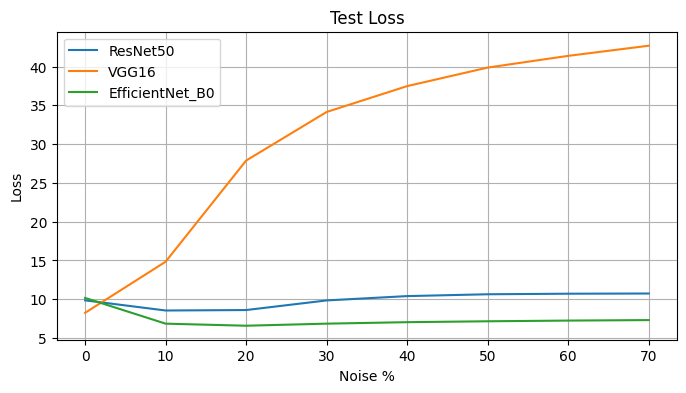

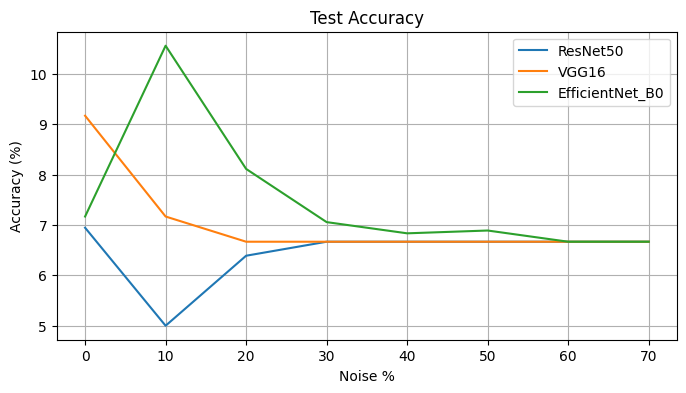

In [ ]:
# Plot test results

import matplotlib.pyplot as plt

modelname = ['ResNet50', 'VGG16', 'EfficientNet_B0']
noise_levels = [0, 10, 20, 30, 40, 50, 60, 70]  

# Plot test loss
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.plot(range(1, len(test_losses[i]) + 1), test_losses[i], label=modelname[i])
plt.grid()
plt.xlabel('Noise %')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.xticks(ticks=range(1, len(noise_levels) + 1), labels=noise_levels) 
plt.legend()
plt.show()

# Plot test accuracy
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.plot(range(1, len(test_accuracies[i]) + 1), test_accuracies[i], label=modelname[i])
plt.grid()
plt.xlabel('Noise %')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.xticks(ticks=range(1, len(noise_levels) + 1), labels=noise_levels) 
plt.legend()
plt.show()
